Добро пожаловать!
В данном ноутбуке представлено исследование данных о студентах курса "Анализ данных в R" на платформе Stepic.org.
Нам предоставлены сырые данные о событиях на платформе по пользователям, а также о решении степов. 

В области открытых онлайн курсов существует следующая проблема: очень большое кол-во людей на них записываются, но лишь 5-10% проходят курс до конца. Таким образом, большая часть учащихся бросают курсы по некоторым причинам. Конечно, хочется уметь по поведению пользователя до определенного момента времени предсказывать, продолжит ли он обучаться на курсе или он его забросил и вряд ли вернется к изучению материала, с целью скорректировать его поведение, то есть предоставить какие-то бонусы или как-то вовремя видоизменить курс, если уходящих пользователей слишком много.

Нам предстоит предобработать данные, выделить важные фичи, выбрать модель, обучить ее, провалидировать, сравнить результаты нескольких способов. Так же мы проведем исследование, какие значимые положительные изменения могут быть достигнуты с точки зрения успешности данного курса.

In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline

In [232]:
path_to_events_train_file = r'~/Documents/datascience/stepic/event_data_train.csv'

In [2]:
events_data = pd.read_csv(path_to_events_train_file)

In [3]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
events_data.shape

(3480703, 4)

In [5]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 4 columns):
step_id      int64
timestamp    int64
action       object
user_id      int64
dtypes: int64(3), object(1)
memory usage: 106.2+ MB


In [6]:
events_data.describe()

,step_id,timestamp,user_id
count,3.480703e+06,3.480703e+06,3.480703e+06
mean,3.487358e+04,1.480288e+09,1.331468e+04
std,1.422243e+04,3.068906e+07,7.779099e+03
min,3.045600e+04,1.434341e+09,1.000000e+00
25%,3.217900e+04,1.450271e+09,6.642000e+03
50%,3.292900e+04,1.483904e+09,1.320800e+04
75%,3.348100e+04,1.507889e+09,2.014400e+04
max,1.584330e+05,1.526773e+09,2.679800e+04


In [7]:
events_data['datetime'] = pd.to_datetime(events_data.timestamp, unit='s')

In [8]:
events_data['date'] = events_data.datetime.dt.date 

In [9]:
events_data.head()

,step_id,timestamp,action,user_id,datetime,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


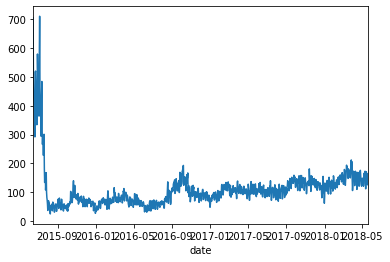

In [10]:
events_data.groupby('date').user_id.nunique().plot()

In [11]:
step_users_count = pd.pivot_table(events_data, values='action', index='user_id', fill_value=0, aggfunc='count', \
                                  columns=events_data.action).reset_index()

In [12]:
step_users_count.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


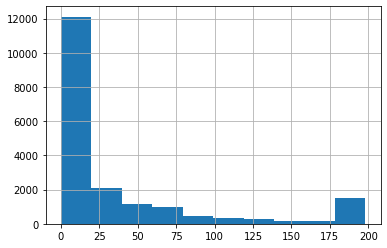

In [13]:
step_users_count.discovered.hist()

In [233]:
path_to_submissions_train_file = r'~/Documents/datascience/stepic/submissions_data_train.csv'

In [14]:
submissions_data = pd.read_csv(path_to_submissions_train_file)

In [15]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [16]:
submissions_data.shape

(509104, 4)

In [17]:
submissions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509104 entries, 0 to 509103
Data columns (total 4 columns):
step_id              509104 non-null int64
timestamp            509104 non-null int64
submission_status    509104 non-null object
user_id              509104 non-null int64
dtypes: int64(3), object(1)
memory usage: 15.5+ MB


In [18]:
submissions_data.submission_status.unique()

array(['correct', 'wrong'], dtype=object)

In [19]:
submissions_data['datetime'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [20]:
submissions_data['date'] = submissions_data.datetime.dt.date 

In [21]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,datetime,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [22]:
users_scores = pd.pivot_table(submissions_data, values='submission_status', columns=submissions_data.submission_status, index='user_id', fill_value=0, aggfunc='count').reset_index()

In [23]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Необходимо понять, какое количество дней неактивности на данном курсе будет считаться порогом для классификации данного пользователя как бросившего курс.
Проанализируем распределение промежутков между активностями у всех пользователей за все время

In [24]:
events_data.head()

,step_id,timestamp,action,user_id,datetime,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [25]:
gap_data = events_data.loc[:, ['user_id', 'date', 'timestamp']].drop_duplicates(subset=['user_id', 'date']).groupby('user_id').timestamp.apply(list).apply(np.diff)

In [26]:
gap_data.head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

Переведем промежутки из секунд в дни:

In [27]:
gap_data = gap_data / 3600 / 24

Соберем все значения в один массив для построения гистограммы:

In [28]:
diff_ar = pd.Series(np.concatenate(gap_data.values, axis=0))

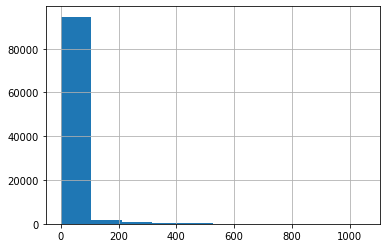

In [29]:
diff_ar.hist()

Посмотрим на данные поближе:

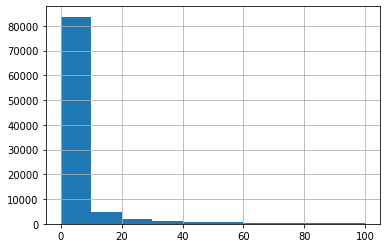

In [30]:
diff_ar[diff_ar<100].hist()

Найдем 90 и 95 процентные квантили распределения, чтобы сделать вывод о том, какое число взять как трешхолд:

In [31]:
diff_ar.quantile(0.95)

59.760440972222156

In [32]:
diff_ar.quantile(0.9)

18.325995370370403

В зависимости от ситуации мы могли бы выбрать необходимый нам уровень уверенности. Для дальнейшей работы в данном случае возьмем порогом число 30:

In [33]:
drop_treshold = 30

Создадим датафрейм users_data, содержащий идентификатор пользователя, таймстемп последнего его визита, а также информацию о том, бросил пользователь курс или нет, согласно нашей метрике. Будем считать пользователя бросившим курс, если с момента его последней активности прошло более, чем drop_treshold (30) дней:

In [34]:
max_timestamp = events_data.timestamp.max()

In [35]:
users_data = events_data.groupby('user_id').agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [36]:
users_data['drop'] = (max_timestamp - users_data.last_timestamp) > drop_treshold

In [37]:
users_data.head()

,last_timestamp,drop
user_id,,
1,1472827464,True
2,1519226966,True
3,1444581588,True
5,1499859939,True
7,1521634660,True


Выделим еще одну важную фичу для дальнейшей работы - кол-во уникальных дней, которые пользователь был на странице курса:

In [38]:
user_days = events_data.groupby('user_id').date.nunique().to_frame().reset_index().rename(columns={'date': 'num_days'})

In [39]:
user_days.head()

,user_id,num_days
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


Соберем все выделенные до этого момента данные в единый датафрейм:

In [40]:
users_info_data = users_data.reset_index().merge(user_days, how='outer', on='user_id') \
    .merge(users_scores, how='outer', on='user_id') \
    .merge(step_users_count, how='outer', on='user_id')

In [41]:
users_info_data.head()

,user_id,last_timestamp,drop,num_days,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,1,NaN,NaN,1,0,0,1
1,2,1519226966,True,2,2.0,0.0,9,9,2,10
2,3,1444581588,True,7,29.0,23.0,91,87,30,192
3,5,1499859939,True,2,2.0,2.0,11,11,4,12
4,7,1521634660,True,1,NaN,NaN,1,1,0,1


In [42]:
users_info_data.isna().sum()

user_id               0
last_timestamp        0
drop                  0
num_days              0
correct            9294
wrong              9294
discovered            0
passed                0
started_attempt       0
viewed                0
dtype: int64

Заметим, что неопределенные значения присутствуют только в колонках correct и wrong. Заполним данные отсутствующие значения нулями, так как данные пользователи не совершили ни одного сабмита.

In [43]:
users_info_data.fillna(0, inplace=True)

Убедимся, что теперь неопределнных значений в нашем датафрейме нет:

In [44]:
users_info_data.isna().sum()

user_id            0
last_timestamp     0
drop               0
num_days           0
correct            0
wrong              0
discovered         0
passed             0
started_attempt    0
viewed             0
dtype: int64

Проверим, что мы не потеряли ни одного уникального пользователя во время обработки данных:

In [45]:
events_data.user_id.nunique()

19234

In [46]:
users_info_data.user_id.nunique()

19234

Также существует еще один важный признак для будущей модели - прошел пользователь данный курс или нет (курс считается пройденным, если пользователь решил хотя бы 172 степа). Выделим эти данные, провалидируем и добавим их к итоговому датафрейму:

In [47]:
done_score = 40

In [48]:
course_done = users_info_data.passed > done_score

In [49]:
course_done.head()

0    False
1    False
2     True
3    False
4    False
Name: passed, dtype: bool

In [50]:
course_done_count = course_done.reset_index().groupby('passed').count().reset_index().rename( \
                                                                                        columns={'index': 'count'})

In [51]:
course_done_count.head()

,passed,count
0,False,14596
1,True,4638


Процент студентов, завершивших курс:

In [52]:
course_done_count[course_done_count.passed == True]['count'].iloc[0] / \
                                (course_done_count[course_done_count.passed == True]['count'].iloc[0] + \
                                 course_done_count[course_done_count.passed == False]['count'][0]) * 100

24.113548923780805

Как видно, результат попадает в общую статистику (5-10%).

In [53]:
users_info_data['passed_course'] = course_done

In [54]:
users_info_data

,user_id,last_timestamp,drop,num_days,correct,wrong,discovered,passed,started_attempt,viewed,passed_course
0,1,1472827464,True,1,0.0,0.0,1,0,0,1,False
1,2,1519226966,True,2,2.0,0.0,9,9,2,10,False
2,3,1444581588,True,7,29.0,23.0,91,87,30,192,True
3,5,1499859939,True,2,2.0,2.0,11,11,4,12,False
4,7,1521634660,True,1,0.0,0.0,1,1,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,4,1.0,0.0,8,8,1,9,False
19230,26793,1510225034,True,1,0.0,0.0,1,0,1,1,False
19231,26794,1512035039,True,9,33.0,9.0,69,69,34,180,True
19232,26797,1509995096,True,2,2.0,0.0,10,10,2,13,False


Мы собрали данные в единую таблицу, которую в дальнейшем сможем использовать для построения обучающих датасетов, а также проанализировали общую динамику развития данного курса.

Теперь необходимо подготовить данные для обучения модели - выбрать для каждого пользователя статистику не за все время, а за какой-то короткий промежуток, чтобы на ранних стадиях обучения иметь способность сказать, продолжит ли данный пользователь учиться или нет. 

Посмотрим на распределение кол-ва дней, которое было потрачено на прохождение курса:

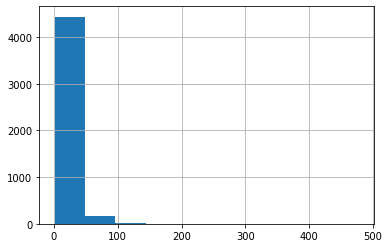

In [55]:
users_info_data[users_info_data.passed_course].num_days.hist()

In [56]:
users_info_data[users_info_data.passed_course].num_days.median()

13.0

Если в среднем курс проходят за 20 дней, хотелось бы ловить уходящих пользователей на этапе 3-5 дней. Заинициализируем данное значение равным 3.

In [57]:
days_to_predict = 2

Теперь необходимо собрать датафрейм, который будет ключать в себя наблюдения только по первым 3-м дням для каждого пользователя. Это и будет наша обучающая выборка.

In [58]:
events_data.head()

,step_id,timestamp,action,user_id,datetime,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [59]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,datetime,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [60]:
user_first_timestamp = events_data.groupby('user_id').timestamp.min().reset_index(). \
    rename(columns={'timestamp': 'min_timestamp'})

In [61]:
user_first_timestamp.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [62]:
events_data = events_data.merge(user_first_timestamp)

In [63]:
events_data.head()

,step_id,timestamp,action,user_id,datetime,date,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [64]:
train_events_data = events_data[events_data.timestamp - events_data.min_timestamp <= days_to_predict * 24 * 3600]

In [65]:
train_events_data.head()

,step_id,timestamp,action,user_id,datetime,date,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [66]:
train_events_data.shape

(906203, 7)

In [67]:
train_events_data.groupby('user_id').date.nunique().max()

3

Повторим данные операции для датафрейма submissions_data:

In [68]:
submissions_data = submissions_data.merge(submissions_data.groupby('user_id').timestamp.min().reset_index(). \
    rename(columns={'timestamp': 'min_timestamp'}))
train_submissions_data = submissions_data[submissions_data.timestamp - submissions_data.min_timestamp <= days_to_predict * 24 * 3600]

In [69]:
train_submissions_data.head()

,step_id,timestamp,submission_status,user_id,datetime,date,min_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434346056
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434346056
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434346056
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1434346056
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,1434346056


In [70]:
train_submissions_data.shape

(134612, 7)

In [71]:
train_submissions_data.groupby('user_id').date.nunique().max()

3

In [72]:
X = train_events_data.groupby('user_id').date.nunique().to_frame().reset_index()

In [73]:
X = X.merge(pd.pivot_table(train_events_data, values='action', index='user_id', fill_value=0, aggfunc='count', \
                                  columns=train_events_data.action).reset_index(), how='outer', on='user_id')

In [74]:
X.head()

,user_id,date,discovered,passed,started_attempt,viewed
0,1,1,1,0,0,1
1,2,1,9,9,2,9
2,3,1,15,15,4,20
3,5,1,1,1,0,1
4,7,1,1,1,0,1


In [75]:
X = X.merge(train_submissions_data.groupby('user_id').step_id.nunique().to_frame().rename(columns= \
                                                        {'step_id': 'steps_tried'}).reset_index())

In [76]:
X = X.merge(pd.pivot_table(train_submissions_data, values='submission_status', columns=train_submissions_data.submission_status, \
               index='user_id', fill_value=0, aggfunc='count').reset_index())

In [77]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [78]:
X

,user_id,date,discovered,passed,started_attempt,viewed,steps_tried,correct,wrong,correct_ratio
0,2,1,9,9,2,9,2,2,0,1.000000
1,3,1,15,15,4,20,4,4,4,0.500000
2,5,1,1,1,0,1,2,2,2,0.500000
3,8,1,109,84,37,154,11,9,21,0.300000
4,14,1,4,3,1,9,1,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...
9935,26787,1,14,13,3,14,3,3,0,1.000000
9936,26790,1,2,2,0,2,1,1,0,1.000000
9937,26794,2,50,50,24,90,22,24,7,0.774194
9938,26797,1,10,10,2,10,2,2,0,1.000000


In [79]:
users_info_data

,user_id,last_timestamp,drop,num_days,correct,wrong,discovered,passed,started_attempt,viewed,passed_course
0,1,1472827464,True,1,0.0,0.0,1,0,0,1,False
1,2,1519226966,True,2,2.0,0.0,9,9,2,10,False
2,3,1444581588,True,7,29.0,23.0,91,87,30,192,True
3,5,1499859939,True,2,2.0,2.0,11,11,4,12,False
4,7,1521634660,True,1,0.0,0.0,1,1,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,4,1.0,0.0,8,8,1,9,False
19230,26793,1510225034,True,1,0.0,0.0,1,0,1,1,False
19231,26794,1512035039,True,9,33.0,9.0,69,69,34,180,True
19232,26797,1509995096,True,2,2.0,0.0,10,10,2,13,False


In [80]:
X = X.merge(users_info_data[['user_id', 'drop', 'passed_course']])

In [81]:
X.head()

,user_id,date,discovered,passed,started_attempt,viewed,steps_tried,correct,wrong,correct_ratio,drop,passed_course
0,2,1,9,9,2,9,2,2,0,1.0,True,False
1,3,1,15,15,4,20,4,4,4,0.5,True,True
2,5,1,1,1,0,1,2,2,2,0.5,True,False
3,8,1,109,84,37,154,11,9,21,0.3,True,True
4,14,1,4,3,1,9,1,0,1,0.0,True,False


Уберем из получившегося датафрейма тех пользователей, которые еще не прошли курс и еще не ушли с него, то есть тех, которые еще находятся в процессе обучения, так как о них мы по сути ничего не знаем, и эти данные бесполезны для модели:

In [82]:
X = X[~((X.passed_course == False) & (X.drop == False))]
X.head()

,user_id,date,discovered,passed,started_attempt,viewed,steps_tried,correct,wrong,correct_ratio,drop,passed_course
0,2,1,9,9,2,9,2,2,0,1.0,True,False
1,3,1,15,15,4,20,4,4,4,0.5,True,True
2,5,1,1,1,0,1,2,2,2,0.5,True,False
3,8,1,109,84,37,154,11,9,21,0.3,True,True
4,14,1,4,3,1,9,1,0,1,0.0,True,False


In [83]:
events_data.head()

,step_id,timestamp,action,user_id,datetime,date,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [84]:
user_first_diff = train_events_data[train_events_data.action == 'passed'][['user_id', 'timestamp']].groupby('user_id').\
    apply(lambda x: (x.iloc[1] if len(x)>1 else (x.iloc[0] + 3600*24*2)) - x.iloc[0]).\
    rename(columns={'timestamp': 'first_diff'})

In [89]:
user_first_diff = user_first_diff.drop('user_id', axis=1).reset_index()

In [90]:
X = X.merge(user_first_diff, how='outer').fillna(0)

Заметим, что нашей целевой переменной является колонка 'passed_course', и вынесем ее в y_train:

In [91]:
y = X.passed_course.astype(int)

In [92]:
X = X.set_index(X.user_id).drop(['user_id', 'drop', 'passed_course'], axis=1).rename(columns={'date': 'days'})

In [93]:
X.head()

,days,discovered,passed,started_attempt,viewed,steps_tried,correct,wrong,correct_ratio,first_diff
user_id,,,,,,,,,,
2,1.0,9.0,9.0,2.0,9.0,2.0,2.0,0.0,1.0,8.0
3,1.0,15.0,15.0,4.0,20.0,4.0,4.0,4.0,0.5,5.0
5,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,0.5,172800.0
8,1.0,109.0,84.0,37.0,154.0,11.0,9.0,21.0,0.3,1.0
14,1.0,4.0,3.0,1.0,9.0,1.0,0.0,1.0,0.0,45.0


Мы сформировали обучающую выборку для модели.

In [94]:
from sklearn import tree

In [95]:
clf = tree.DecisionTreeClassifier()

In [96]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [97]:
grid_search = GridSearchCV(clf, param_grid=[{'max_depth': range(2, 11),
                                             'criterion': ['entropy', 'gini'],
                                             'min_samples_split': range(2, 16),
                                             'min_samples_leaf': range(1, 6)}], cv=5, n_jobs=-1, scoring='roc_auc')

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [99]:
y_train.to_frame().reset_index().groupby('passed_course').count()

,index
passed_course,
0,8973
1,3119


In [100]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': range(2, 11),
                         

In [101]:
best_tree = grid_search.best_estimator_
best_tree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [102]:
best_tree.feature_importances_

array([0.00440354, 0.00297491, 0.04724472, 0.00350936, 0.60809322,
       0.06641725, 0.25506249, 0.00257289, 0.00972162, 0.        ])

In [103]:
from sklearn.model_selection import cross_val_score

In [104]:
y_pred_tree = best_tree.predict(X_test)
cross_val_score(best_tree, X_test, y_test, cv=5, scoring='roc_auc').mean()

0.8973658629760501

In [105]:
import seaborn as sns

In [106]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix, f1_score, precision_recall_fscore_support

In [107]:
precision_recall_fscore_support(y_test, y_pred_tree)

(array([0.86260658, 0.7903525 ]),
 array([0.94000531, 0.60169492]),
 array([0.89964431, 0.68323978]),
 array([3767, 1416]))

Как можно заметить, модель неплохо показывает себя для решения нашей задачи - recall, precision и f_score для отрицательного класса выше 70%. Попробуем составить более сложную модель и посмотреть на ее показатели:

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [109]:
randomized_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions={
    'n_estimators': range(100, 501, 100),
    'max_depth': range(2, 11),
    'criterion': ['entropy', 'gini'],
    'min_samples_split': range(2, 16),
    'min_samples_leaf': range(1, 6)}, cv=10, scoring='roc_auc', n_jobs=-1)

In [110]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=Non

In [111]:
best_rf = randomized_search.best_estimator_
best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [112]:
best_rf.feature_importances_

array([0.10137723, 0.15344327, 0.12473869, 0.02646567, 0.1583189 ,
       0.19907665, 0.14597809, 0.01015158, 0.0733725 , 0.00707742])

In [113]:
y_pred_rf = best_rf.predict_proba(X_test)
cross_val_score(best_rf, X_test, y_test, cv=10, scoring='roc_auc').mean()

0.9162997293078636

In [114]:
y_pred_rf

array([[0.73928393, 0.26071607],
       [0.52364082, 0.47635918],
       [0.73383063, 0.26616937],
       ...,
       [0.62599053, 0.37400947],
       [0.56628672, 0.43371328],
       [1.        , 0.        ]])

In [115]:
precision_recall_fscore_support(y_test, np.where(y_pred_rf[:, 1] > 0.6, 1, 0))

(array([0.83348478, 0.87451985]),
 array([0.9739846 , 0.48234463]),
 array([0.89827396, 0.62175694]),
 array([3767, 1416]))

In [116]:
confusion_matrix(y_test, np.where(y_pred_rf[:, 1] > 0.6, 1, 0))

array([[3669,   98],
       [ 733,  683]])

Заметим, что сильно упал recall для положительного класса, в то время как recall для тех, кто курс бросил поднялся до 0.98. Посмотрим на корреляцию фичей:

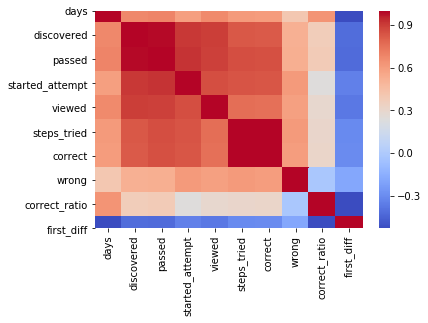

In [117]:
sns.heatmap(X_train.corr(), cmap='coolwarm')

In [118]:
X_train.corr()

,days,discovered,passed,started_attempt,viewed,steps_tried,correct,wrong,correct_ratio,first_diff
days,1.000000,0.682333,0.692658,0.597880,0.672987,0.612244,0.607187,0.412421,0.640613,-0.527284
discovered,0.682333,1.000000,0.991969,0.915689,0.902344,0.832134,0.824297,0.527592,0.372862,-0.412409
passed,0.692658,0.991969,1.000000,0.923069,0.895423,0.859037,0.854578,0.528441,0.385567,-0.416575
started_attempt,0.597880,0.915689,0.923069,1.000000,0.860995,0.844050,0.838585,0.612827,0.246805,-0.339404
viewed,0.672987,0.902344,0.895423,0.860995,1.000000,0.764701,0.758533,0.588893,0.297898,-0.373097
steps_tried,0.612244,0.832134,0.859037,0.844050,0.764701,1.000000,0.996207,0.615695,0.310429,-0.304249
correct,0.607187,0.824297,0.854578,0.838585,0.758533,0.996207,1.000000,0.601280,0.316947,-0.300022
wrong,0.412421,0.527592,0.528441,0.612827,0.588893,0.615695,0.601280,1.000000,-0.017443,-0.186846
correct_ratio,0.640613,0.372862,0.385567,0.246805,0.297898,0.310429,0.316947,-0.017443,1.000000,-0.529075
first_diff,-0.527284,-0.412409,-0.416575,-0.339404,-0.373097,-0.304249,-0.300022,-0.186846,-0.529075,1.000000


Заметим, что "steps_tried", "correct" и "discovered" сильно коррелируют со множеством признаков. Удалим данные фичи, и обучим модель на новых данных:

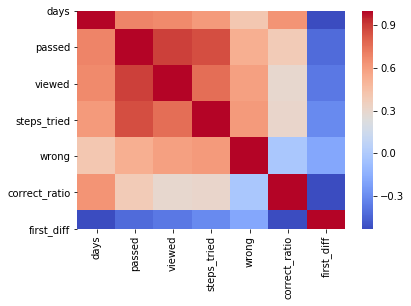

In [119]:
sns.heatmap(X_train.drop(['discovered', 'started_attempt', 'correct'], axis=1).corr(), cmap='coolwarm')

In [120]:
clean_X_train = X_train.drop(['discovered', 'started_attempt'], axis=1)
clean_X_test = X_test.drop(['discovered', 'started_attempt'], axis=1)

In [121]:
clean_X_train

,days,passed,viewed,steps_tried,correct,wrong,correct_ratio,first_diff
user_id,,,,,,,,
25092,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,20.0
23529,1.0,2.0,4.0,1.0,1.0,0.0,1.000000,2273.0
13231,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,172800.0
4585,3.0,40.0,69.0,16.0,18.0,12.0,0.600000,11.0
25192,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,172800.0
...,...,...,...,...,...,...,...,...
25852,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,172800.0
7082,1.0,15.0,22.0,4.0,4.0,0.0,1.000000,29.0
5716,1.0,8.0,21.0,2.0,3.0,3.0,0.500000,27.0


In [122]:
randomized_search.fit(clean_X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=Non

In [123]:
best_rf_2 = randomized_search.best_estimator_

In [124]:
best_rf_2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [125]:
y_pred_rf_2 = best_rf_2.predict_proba(clean_X_test)
cross_val_score(best_rf_2, clean_X_test, y_test, cv=10, scoring='roc_auc').mean()

0.915006338560627

In [126]:
confusion_matrix(y_test, np.where(y_pred_rf_2[:, 1] > 0.6, 1, 0))

array([[3665,  102],
       [ 711,  705]])

In [127]:
precision_recall_fscore_support(y_test, np.where(y_pred_rf_2[:, 1] > 0.6, 1, 0))

(array([0.83752285, 0.87360595]),
 array([0.97292275, 0.49788136]),
 array([0.90015965, 0.634278  ]),
 array([3767, 1416]))

In [128]:
best_rf_2.feature_importances_

array([0.13675243, 0.19139417, 0.16523042, 0.21210956, 0.1558855 ,
       0.03977942, 0.08914717, 0.00970133])

Заметим, что рандомный лес выделил более общие зависимости из наших данных, показатели качества данной модели также превосходят показатели качества обычного дерева решений и логистической регрессии.

Таким образом, именно эту модель мы и будем считать результатом решения задачи. В дальнейшем можно провести более глубокий фичеинжениринг и собрать больше данных, перестроить модели, и, возможно получить более качественный результат.

In [234]:
path_to_events_test_file = r'~/Documents/datascience/stepic/events_data_test.csv'

In [174]:
test_events_data = pd.read_csv(path_to_events_test_file)

In [235]:
path_to_submissions_test_file = r'~/Documents/datascience/stepic/submission_data_test.csv'

In [175]:
test_submissions_data = pd.read_csv(path_to_submissions_test_file)

In [176]:
test_events_data.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [177]:
test_submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [178]:
test_events_data['datetime'] = pd.to_datetime(test_events_data.timestamp, unit='s')

In [179]:
test_events_data['date'] = test_events_data.datetime.dt.date 

In [180]:
test_events_data.head()

,step_id,timestamp,action,user_id,datetime,date
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


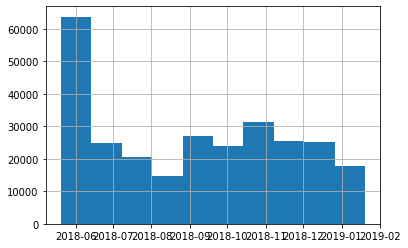

In [181]:
test_events_data.date.hist()

In [182]:
test_submissions_data['datetime'] = pd.to_datetime(test_submissions_data.timestamp, unit='s')

In [183]:
test_submissions_data['date'] = test_submissions_data.datetime.dt.date 

In [184]:
test_submissions_data.head()

,step_id,timestamp,submission_status,user_id,datetime,date
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [185]:
test_user_first_timestamp = test_events_data.groupby('user_id').timestamp.min().to_frame().reset_index().\
    rename(columns={'timestamp': 'first_timestamp'})

In [186]:
test_user_first_timestamp.head()

,user_id,first_timestamp
0,4,1529331707
1,6,1546889407
2,10,1534585756
3,12,1537348474
4,13,1533034354


In [187]:
test_users_scores = pd.pivot_table(test_submissions_data, values='submission_status', columns=test_submissions_data.submission_status, index='user_id', fill_value=0, aggfunc='count').reset_index()

In [188]:
test_users_scores.head()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35


In [189]:
test_user_days = test_events_data.groupby('user_id').date.nunique().to_frame().reset_index().rename(columns={'date': 'num_days'})

In [190]:
test_user_days.head()

,user_id,num_days
0,4,1
1,6,1
2,10,1
3,12,1
4,13,2


In [191]:
test_user_days.num_days.unique()

array([1, 2, 3])

In [192]:
test_step_users_count = pd.pivot_table(test_events_data, values='action', index='user_id', fill_value=0, aggfunc='count', \
                                  columns=test_events_data.action).reset_index()

In [193]:
test_step_users_count.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [194]:
test_X = test_user_days.merge(test_users_scores, how='outer', on='user_id') \
    .merge(test_step_users_count, how='outer', on='user_id')

In [195]:
test_X = test_X.merge(test_submissions_data.groupby('user_id').step_id.nunique().to_frame().\
                    rename(columns={'step_id': 'steps_tried'}).reset_index(), how='outer') 

In [196]:
test_X.isna().sum()

user_id               0
num_days              0
correct            3381
wrong              3381
discovered            0
passed                0
started_attempt       0
viewed                0
steps_tried        3381
dtype: int64

In [197]:
test_X.head()

,user_id,num_days,correct,wrong,discovered,passed,started_attempt,viewed,steps_tried
0,4,1,NaN,NaN,1,1,0,1,NaN
1,6,1,NaN,NaN,1,1,0,1,NaN
2,10,1,NaN,NaN,2,2,0,6,NaN
3,12,1,1.0,0.0,11,9,4,14,1.0
4,13,2,29.0,36.0,70,70,35,105,29.0


In [198]:
test_X.fillna(0, inplace=True)

In [199]:
test_X.isna().sum()

user_id            0
num_days           0
correct            0
wrong              0
discovered         0
passed             0
started_attempt    0
viewed             0
steps_tried        0
dtype: int64

In [200]:
test_X.head()

,user_id,num_days,correct,wrong,discovered,passed,started_attempt,viewed,steps_tried
0,4,1,0.0,0.0,1,1,0,1,0.0
1,6,1,0.0,0.0,1,1,0,1,0.0
2,10,1,0.0,0.0,2,2,0,6,0.0
3,12,1,1.0,0.0,11,9,4,14,1.0
4,13,2,29.0,36.0,70,70,35,105,29.0


In [201]:
test_events_data.user_id.nunique()

6184

In [202]:
test_X.index.nunique()

6184

In [203]:
test_X['correct_ratio'] = test_X.correct / (test_X.correct + test_X.wrong)

In [204]:
test_user_step_disc_pass = test_events_data[test_events_data.action == 'passed'][['step_id', 'user_id', 'timestamp']].\
    rename(columns={'timestamp': 'passed_tmp'}). \
    merge(test_events_data[events_data.action == 'viewed'][['user_id', 'step_id', 'timestamp']], how='left', on=['user_id', 'step_id'])

/home/bureevda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [205]:
test_user_step_disc_pass.head()

,step_id,user_id,passed_tmp,timestamp
0,30456,24417,1526893787,1.526894e+09
1,30456,24417,1526893787,1.526894e+09
2,30462,24417,1526894867,1.526895e+09
3,30462,24417,1526894867,1.526899e+09
4,30465,24417,1526894143,1.526894e+09


In [206]:
test_user_step_disc_pass['diff'] = test_user_step_disc_pass.passed_tmp - test_user_step_disc_pass.timestamp

In [207]:
test_user_step_disc_pass.groupby('user_id').diff.mean()

user_id
4           0.000000
6           0.000000
10      -1368.000000
12         -4.882353
13        351.500000
            ...     
26785       0.000000
26791       0.000000
26795       0.000000
26796     -27.111111
26799      11.500000
Name: diff, Length: 5551, dtype: float64

In [208]:
test_user_step_disc_pass.groupby('user_id').diff.mean().to_frame().reset_index()

,user_id,diff
0,4,0.000000
1,6,0.000000
2,10,-1368.000000
3,12,-4.882353
4,13,351.500000
...,...,...
5546,26785,0.000000
5547,26791,0.000000
5548,26795,0.000000
5549,26796,-27.111111


In [209]:
user_first_diff = train_events_data[train_events_data.action == 'passed'][['user_id', 'timestamp']].groupby('user_id').\
    apply(lambda x: (x.iloc[1] if len(x)>1 else (x.iloc[0] + 3600*24*2)) - x.iloc[0]).\
    rename(columns={'timestamp': 'first_diff'})

In [210]:
user_first_diff = user_first_diff.drop('user_id', axis=1).reset_index()

In [211]:
test_X = test_X.merge(user_first_diff, how='outer').fillna(0)

In [212]:
test_X = test_X.fillna(0).set_index('user_id').rename(columns={'num_days': 'days'}).\
    reindex(columns=['days', 'discovered', 'passed', 'started_attempt', 'viewed', 'steps_tried', 'correct', 'wrong', 'correct_ratio', 'first_diff'])

In [213]:
test_X.head()

,days,discovered,passed,started_attempt,viewed,steps_tried,correct,wrong,correct_ratio,first_diff
user_id,,,,,,,,,,
4,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
6,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
10,1.0,2.0,2.0,0.0,6.0,0.0,0.0,0.0,0.000000,0.0
12,1.0,11.0,9.0,4.0,14.0,1.0,1.0,0.0,1.000000,0.0
13,2.0,70.0,70.0,35.0,105.0,29.0,29.0,36.0,0.446154,0.0


In [222]:
clean_test_X = test_X.drop(['started_attempt', 'discovered'], axis=1)

In [221]:
clean_X_train.head()

,days,passed,viewed,steps_tried,correct,wrong,correct_ratio,first_diff
user_id,,,,,,,,
25092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
23529,1.0,2.0,4.0,1.0,1.0,0.0,1.0,2273.0
13231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172800.0
4585,3.0,40.0,69.0,16.0,18.0,12.0,0.6,11.0
25192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172800.0


In [226]:
y_pred_rf_2 = best_rf_2.predict_proba(clean_test_X)

In [227]:
pd.DataFrame(index=clean_test_X.index, data=y_pred_rf_2[:, 1]).rename(columns={0: 'is_gone'}).to_csv('result.csv')

In [229]:
result = pd.DataFrame(index=test_X.index, data=y_pred_rf_2[:, 1]).rename(columns={0: 'is_gone'})

In [230]:
result['isgone'] = result.is_gone > 0.6

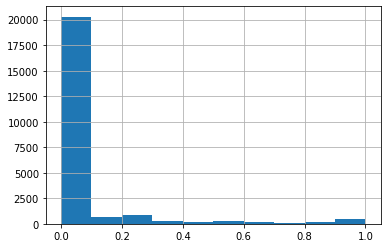

In [231]:
result.is_gone.hist()

ROC_AUC score на тесте - 0.883